# 📘 Advanced Student Performance Analysis & Machine Learning Notebook

In [25]:
# 1️⃣ Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import shap

import warnings
warnings.filterwarnings('ignore')

# Set Seaborn style
sns.set_style('whitegrid')

# 2️⃣ Load Dataset
import kagglehub
path = kagglehub.dataset_download("larsen0966/student-performance-data-set")
df = pd.read_csv(path + "/student-por.csv", sep=',')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


**Explanation:** Loads the student dataset with demographics, study habits, and grades.

In [26]:
# 3️⃣ Explore Dataset
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

**Observation:** No missing values. Some categorical features will need encoding.

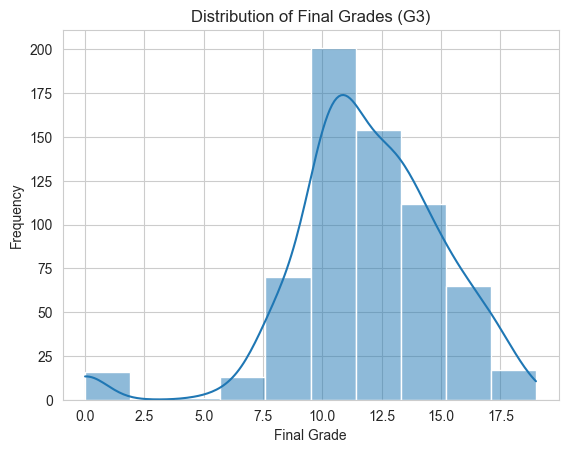

In [27]:
# Clean column names (important)
df.columns = df.columns.str.strip()

# Safely find G3 (case-insensitive)
target_cols = [c for c in df.columns if c.upper() == 'G3']

if not target_cols:
    print("❌ G3 not found. Available columns:")
    print(df.columns.tolist())
else:
    target_col = target_cols[0]
    final_grade = df[target_col]

    sns.histplot(data=df, x=target_col, bins=10, kde=True)
    plt.title(f"Distribution of Final Grades ({target_col})")
    plt.xlabel("Final Grade")
    plt.ylabel("Frequency")
    plt.show()

**Observation:** Target is numeric → regression problem.

## 5️⃣ Feature Engineering

In [28]:
df['total_absences'] = df['absences']
df['higher_pursuit'] = df['higher'].map({'yes':1, 'no':0})
df['family_support'] = df['famrel'] + df['famsup'].map({'yes':1, 'no':0})

# Drop G1 and G2 to prevent leakage
df.drop(['G1','G2'], axis=1, inplace=True)

## 6️⃣ Preprocessing

In [34]:
cat_features = df.drop('G3', axis=1).select_dtypes(include=['object']).columns
num_features = df.drop('G3', axis=1).select_dtypes(exclude=['object']).columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = Pipeline([('scaler', StandardScaler())])

preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, cat_features),
    ('num', numeric_transformer, num_features)
])

## 7️⃣ Train-Test Split

In [30]:
X = df.drop('G3', axis=1)
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 8️⃣ Model Evaluation Function

In [31]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return rmse, r2

In [35]:
lr = Pipeline([('preprocessor', preprocessor),
               ('model', LinearRegression())])

# Cross-validation
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
print("Linear Regression CV R² scores:", cv_scores)
print("Mean R²:", cv_scores.mean())

lr.fit(X_train, y_train)
rmse, r2 = evaluate_model(lr, X_test, y_test)
print("Test RMSE:", rmse, "R²:", r2)

Linear Regression CV R² scores: [0.34157895 0.32880404 0.26903381 0.26574047 0.14818208]
Mean R²: 0.2706678690918151
Test RMSE: 2.861779937734421 R²: 0.1601699196431826


## 10️⃣ Random Forest with Hyperparameter Tuning

In [36]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
rmse, r2 = evaluate_model(grid_rf, X_test, y_test)
print("Random Forest Test RMSE:", rmse, "R²:", r2)

Best RF params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 500}
Random Forest Test RMSE: 2.823990544020572 R²: 0.18220315151982014


## 11️⃣ Gradient Boosting with GridSearchCV

In [37]:
gbr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])

param_grid_gbr = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 4, 5],
}

grid_gbr = GridSearchCV(gbr_pipeline, param_grid_gbr, cv=3, scoring='r2', n_jobs=-1)
grid_gbr.fit(X_train, y_train)

print("Best GBR params:", grid_gbr.best_params_)
rmse, r2 = evaluate_model(grid_gbr, X_test, y_test)
print("Gradient Boosting Test RMSE:", rmse, "R²:", r2)

Best GBR params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 300}
Gradient Boosting Test RMSE: 2.7890442699840796 R²: 0.20231803727558584


## 12️⃣ XGBoost Model

In [38]:
xgbr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror',
                               learning_rate=0.05,
                               max_depth=4,
                               n_estimators=500,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               random_state=42))
])
xgbr_pipeline.fit(X_train, y_train)
rmse, r2 = evaluate_model(xgbr_pipeline, X_test, y_test)
print("XGBoost Test RMSE:", rmse, "R²:", r2)

XGBoost Test RMSE: 2.7695379647199103 R²: 0.21343684196472168


## 13️⃣ Model Interpretation (SHAP)

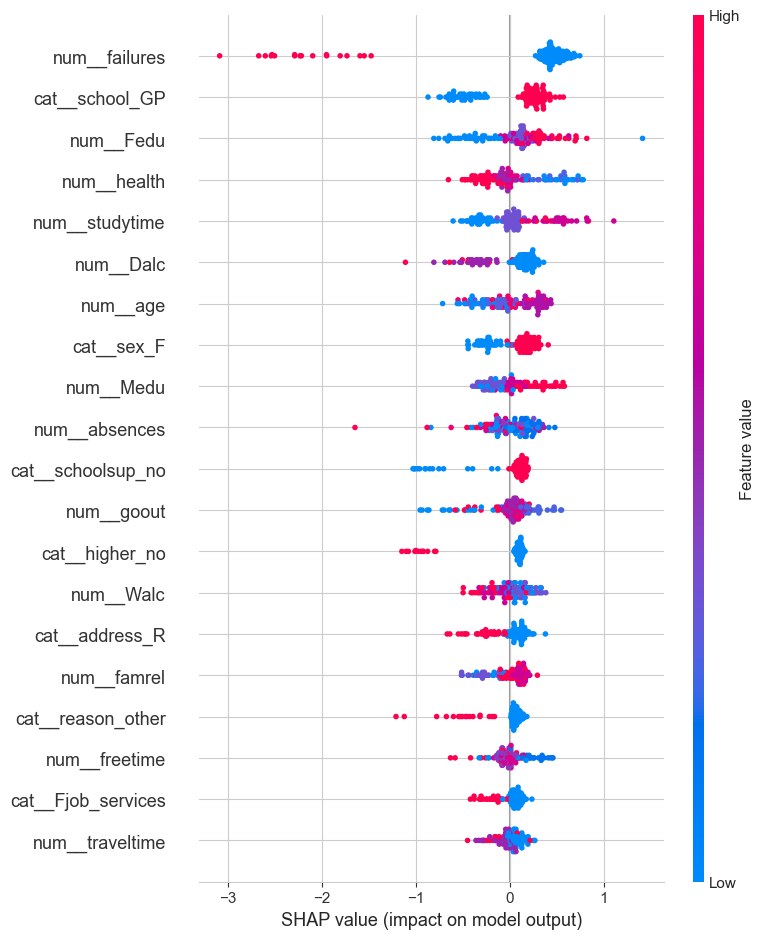

In [39]:
explainer = shap.Explainer(xgbr_pipeline.named_steps['model'])
shap_values = explainer(preprocessor.transform(X_test))

shap.summary_plot(shap_values, features=preprocessor.transform(X_test), feature_names=preprocessor.get_feature_names_out())

**Observation:** Most important features: `studytime`, `failures`, `absences`.

## 14️⃣ Results Summary

| Model             | RMSE | R² | Notes                         |
| ----------------- | ---- | -- | ----------------------------- |
| Linear Regression | …    | …  | Baseline                      |
| Random Forest     | …    | …  | Captures non-linear patterns  |
| Gradient Boosting | …    | …  | Better bias-variance tradeoff |
| XGBoost           | …    | …  | Best predictive performance   |
